<a href="https://colab.research.google.com/github/JJooKim/detecting_defective_product/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/Projects/defective_product_classification

/content/drive/MyDrive/Projects/defective_product_classification


In [4]:
import numpy as np
import pandas as pd
data_path = './'
train = pd.read_csv(data_path + 'train.csv', encoding='utf-8')

In [5]:
train.shape

(10000, 12)

In [6]:
train.info()
# wtcd NULL value 있다

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    10000 non-null  int64  
 1   Num      10000 non-null  object 
 2   prod     10000 non-null  object 
 3   insp     10000 non-null  object 
 4   date     10000 non-null  object 
 5   buydate  10000 non-null  object 
 6   ingr_A   10000 non-null  float64
 7   ingr_B   10000 non-null  float64
 8   ingr_C   10000 non-null  float64
 9   wtcd     9989 non-null   object 
 10  gram     10000 non-null  float64
 11  label    10000 non-null  int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 937.6+ KB


## EDA를 위한 전처리

In [7]:
train.head()

,index,Num,prod,insp,date,buydate,ingr_A,ingr_B,ingr_C,wtcd,gram,label
0,2,20230618산천074246A,GBMD,C,2023-06-18,2023-09-18,399.4063,6.4035,6.9409,F3,970.32,1
1,9,20230518창하053396B,GGMD,L,2023-05-18,2023-07-08,130.0951,5.8245,6.2857,F1,2490.08,0
2,10,20230505창하063135B,KCMD,C,2023-05-05,2023-07-02,131.5192,5.8040,6.0607,F3,487.37,0
3,12,20230505산천001612A,GBMD,K,2023-05-05,2023-06-04,128.5978,6.8720,6.1705,F3,707.94,1
4,16,20230409수성016088C,JJBB,K,2023-04-09,2023-04-14,320.6915,5.7474,6.3695,F3,1978.66,0


### index, Column Drop
* 아무 의미 없는 unique value이므로 Drop

In [8]:
train = train.drop(columns = ['index'])

### Num Column 범주형 변수로 전처리
* 제품번호 문자열의 가운데 깨진 글자들은 범주형으로 봐도 될 것 같음.

In [9]:

train['region'] = train['Num'].str[8:-7]

region_mapping = {
  '산천': 'Sanchun',
  '창하': 'Changha',
  '수성': 'Susung',
  '오포': 'Opo',
}


train['region'] = train['region'].map(region_mapping)


train['Num'] = train['Num'].str[-1]

### `date`, `buydate` Column 구성 요소별로 Column 나누기
* 연, 월, 일로 나누기

In [10]:
train['date_year'] = train['date'].apply(lambda x: x.split('-')[0])
train['date_month'] = train['date'].apply(lambda x: x.split('-')[1])
train['date_day'] = train['date'].apply(lambda x: x.split('-')[2])

In [11]:
train['buydate_year'] = train['buydate'].apply(lambda x: x.split('-')[0])
train['buydate_month'] = train['buydate'].apply(lambda x: x.split('-')[1])
train['buydate_day'] = train['buydate'].apply(lambda x: x.split('-')[2])

### `date`, `buydate`에 대한 요일 Column 만들기
* 연, 월, 일로 나누기

In [12]:
from datetime import datetime
import calendar

train['date_weekday'] = train['date'].apply(
    lambda dateString:
    calendar.day_name[datetime.strptime(dateString, "%Y-%m-%d").weekday()])

In [13]:
train['buydate_weekday'] = train['buydate'].apply(
    lambda dateString:
    calendar.day_name[datetime.strptime(dateString, "%Y-%m-%d").weekday()])

### 검수일자 구입일자 간의 날짜 차이를 나타내는 `days_between` column 생성
* 의미 있을 듯?

In [14]:
train['days_between'] = (pd.to_datetime(train['buydate']) - pd.to_datetime(train['date'])).dt.days

## EDA

In [15]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

### Class 분포 확인

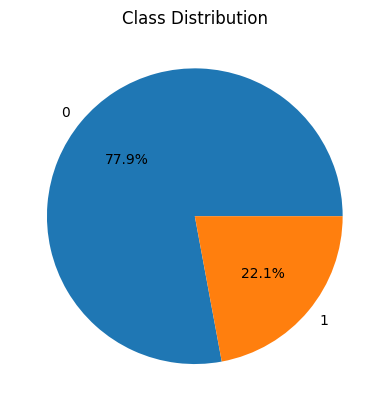

In [16]:
plt.pie(train["label"].value_counts(), labels=['0','1'], autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

### Date 에 따른 label 분포

In [17]:
# 분포 비율을 표시하기위한 함수

def write_percent(ax):

  for idx, patch in enumerate(ax.patches):
    height = patch.get_height()
    width = patch.get_width()
    left_coord = patch.get_x()

    if idx < int(len(ax.patches) / 2):
      total_size = height + ax.patches[int(idx + len(ax.patches) / 2 )].get_height()
    else:
      total_size = height + ax.patches[int(idx - len(ax.patches) / 2 )].get_height()
    percent = height / total_size*100

    ax.text(x=left_coord + width/2.0,
            y=height + total_size*0.001,
            s=f'{percent:1.1f}%',
            ha='center', size=12)


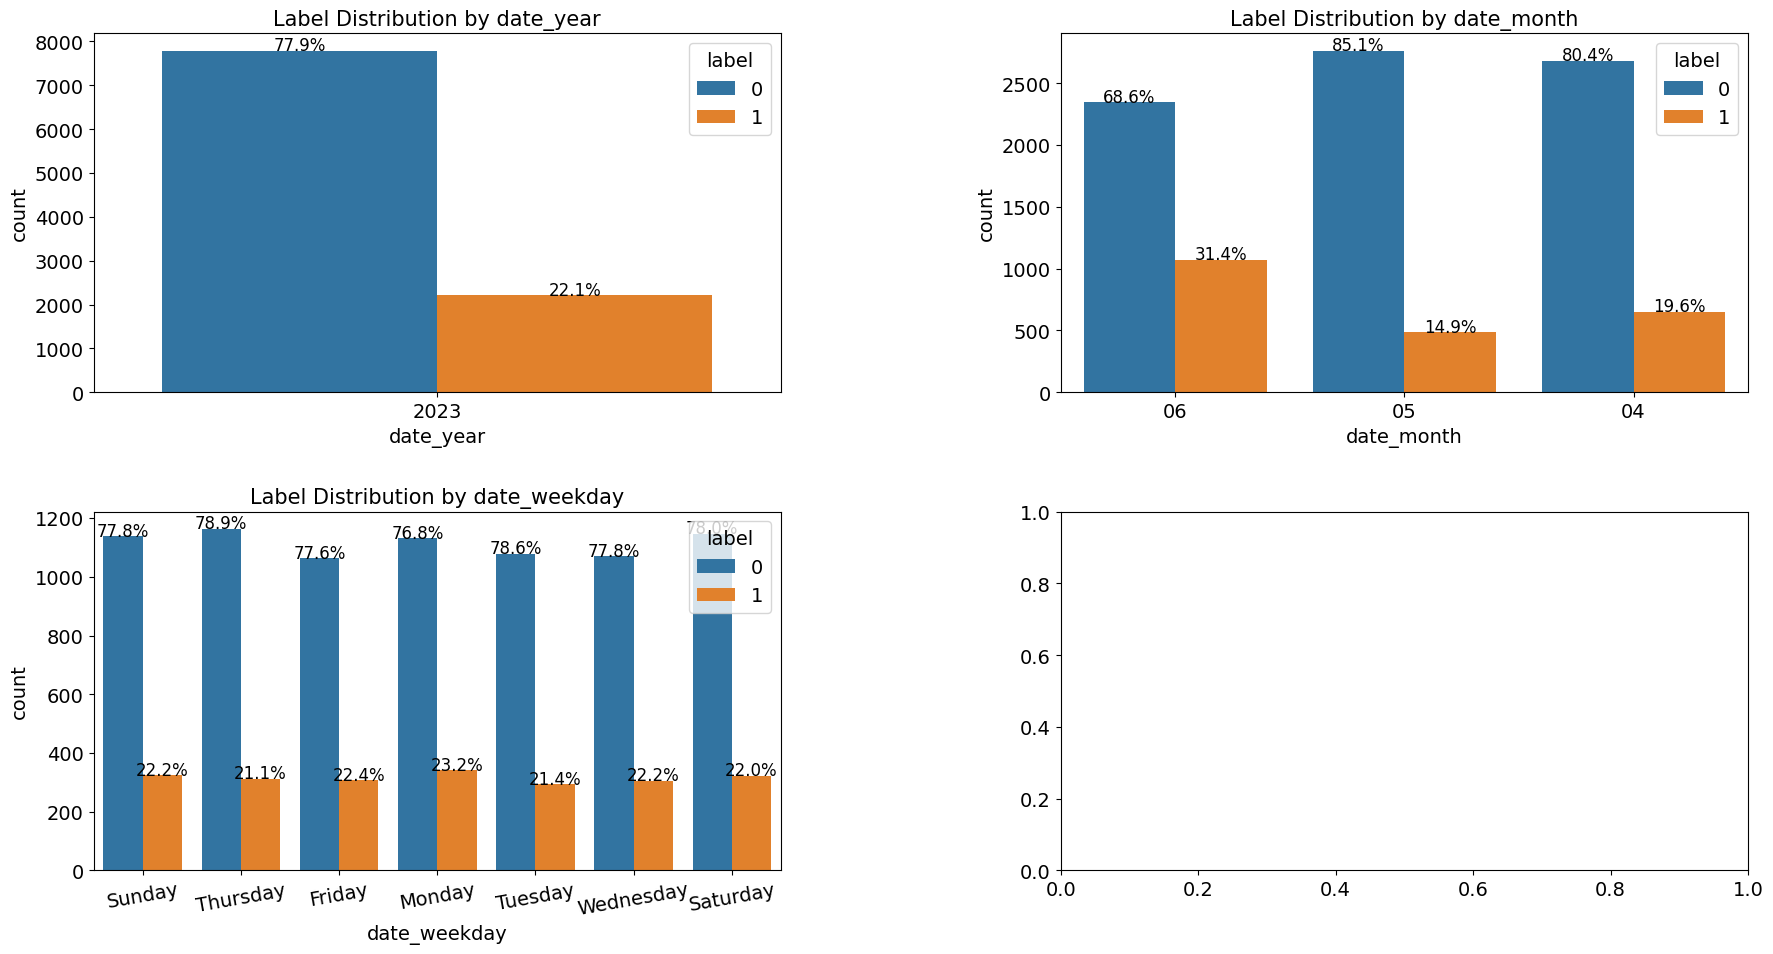

In [18]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열 Figure 생성
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(20,10) # 전체 Figure 크기를 10 x 9인치로 설정

sns.countplot(x='date_year', data=train, hue='label', ax=axes[0,0])
sns.countplot(x='date_month', data=train, hue='label', ax=axes[0,1])
sns.countplot(x='date_weekday', data=train, hue='label', ax=axes[1,0])

axes[0, 0].set(title='Label Distribution by date_year')
axes[0, 1].set(title='Label Distribution by date_month')
axes[1, 0].set(title='Label Distribution by date_weekday')
axes[1, 0].tick_params(axis='x', labelrotation=10)

write_percent(axes[0,0])

write_percent(axes[0,1])

write_percent(axes[1,0])

### 월간 label 추이 based on Data Month

In [21]:
label_count = train.groupby(['date', 'label']).size().reset_index(name='count')
label_count_4 = label_count[label_count['date'].str[6]=='4']
label_count_5 = label_count[label_count['date'].str[6]=='5']
label_count_6 = label_count[label_count['date'].str[6]=='6']

[Text(0, 0, '01'),
 Text(1, 0, '02'),
 Text(2, 0, '03'),
 Text(3, 0, '04'),
 Text(4, 0, '05'),
 Text(5, 0, '06'),
 Text(6, 0, '07'),
 Text(7, 0, '08'),
 Text(8, 0, '09'),
 Text(9, 0, '10'),
 Text(10, 0, '11'),
 Text(11, 0, '12'),
 Text(12, 0, '13'),
 Text(13, 0, '14'),
 Text(14, 0, '15'),
 Text(15, 0, '16'),
 Text(16, 0, '17'),
 Text(17, 0, '18'),
 Text(18, 0, '19'),
 Text(19, 0, '20'),
 Text(20, 0, '21'),
 Text(21, 0, '22'),
 Text(22, 0, '23'),
 Text(23, 0, '24'),
 Text(24, 0, '25'),
 Text(25, 0, '26'),
 Text(26, 0, '27'),
 Text(27, 0, '28'),
 Text(28, 0, '29')]

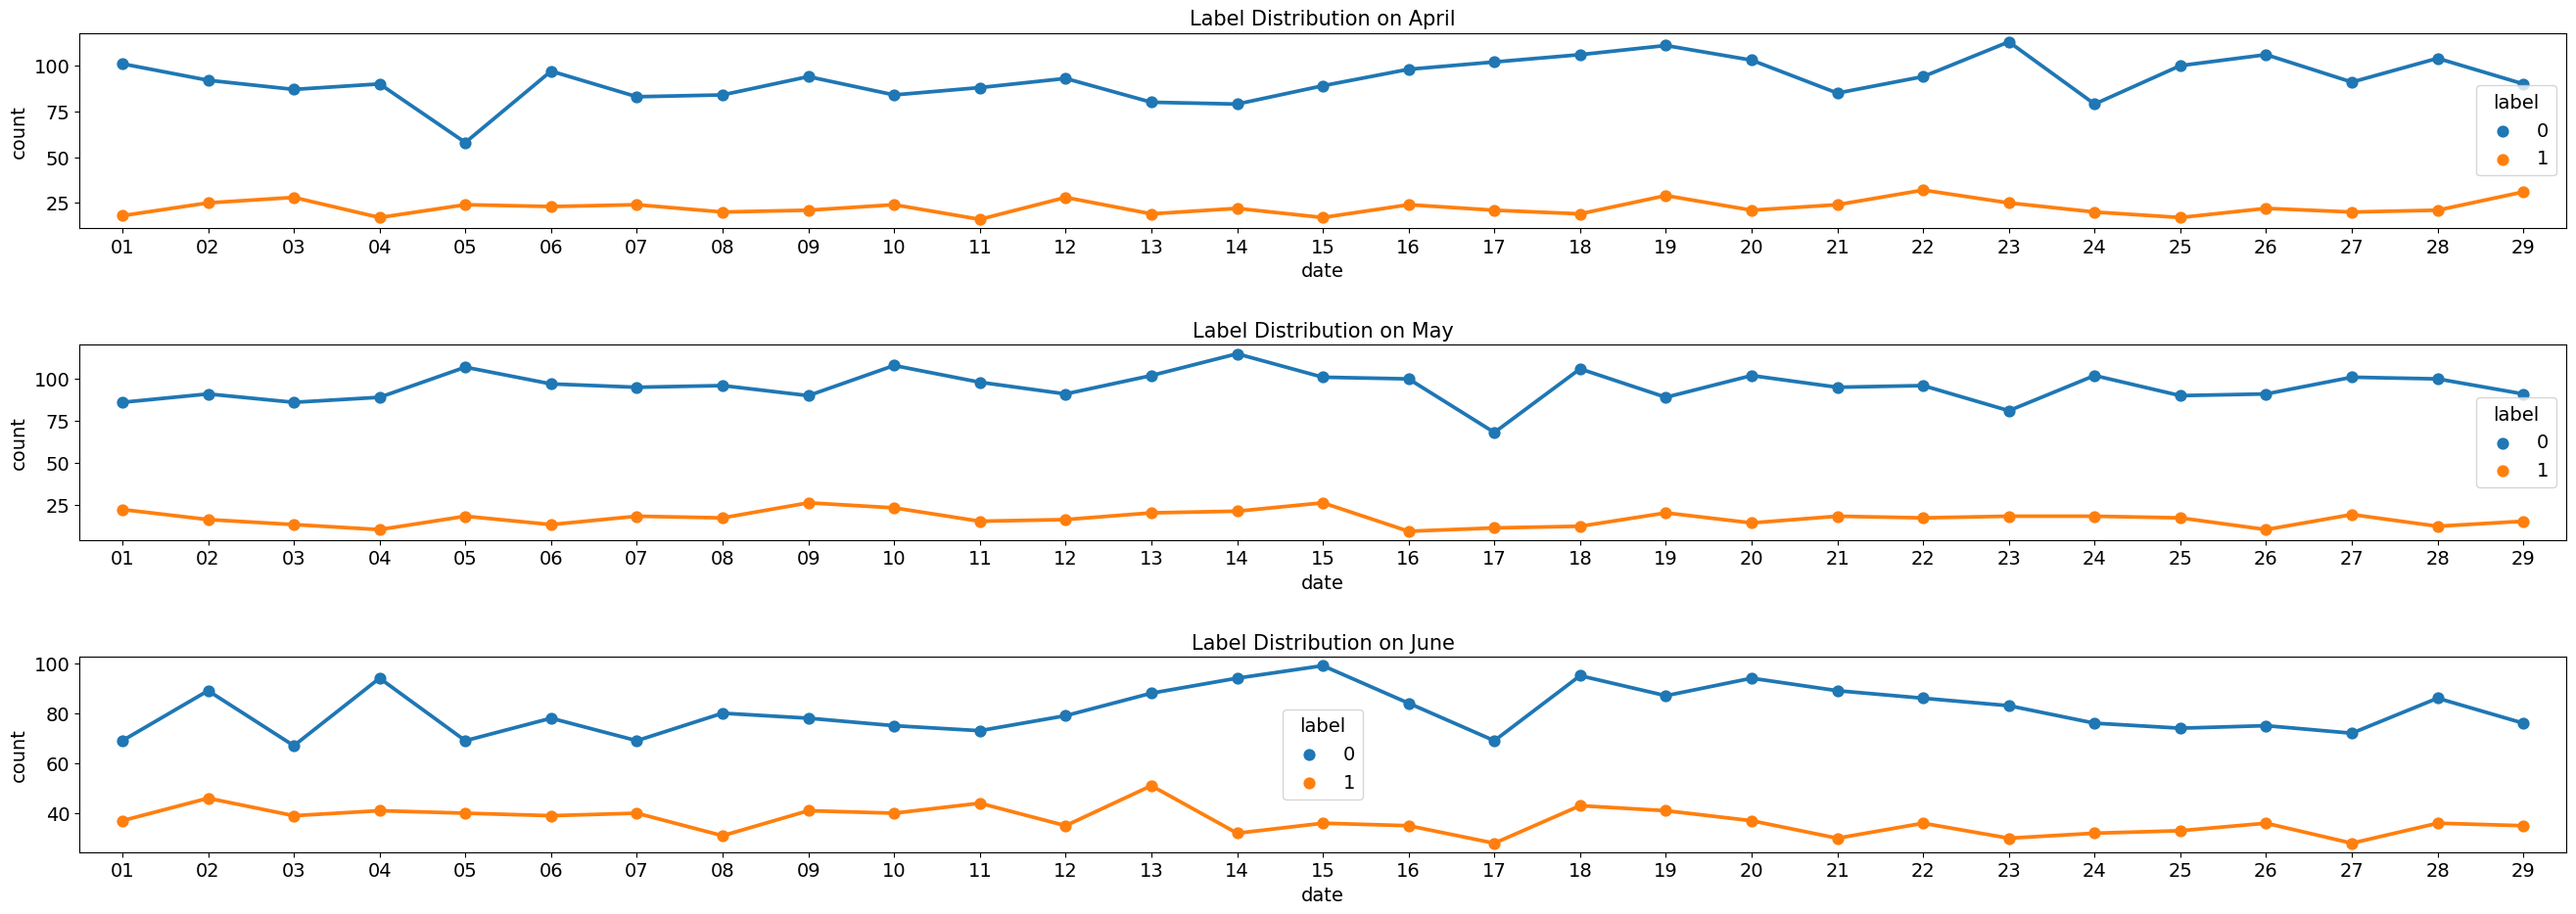

In [22]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=3, ncols=1) # 2행 2열 Figure 생성
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(30,10) # 전체 Figure 크기를 10 x 9인치로 설정

sns.pointplot(x='date', y='count', data=label_count_4, hue='label', ax=axes[0])
sns.pointplot(x='date', y='count', data=label_count_5, hue='label', ax=axes[1])
sns.pointplot(x='date', y='count', data=label_count_6, hue='label', ax=axes[2])


axes[0].set(title='Label Distribution on April')
axes[1].set(title='Label Distribution on May')
axes[2].set(title='Label Distribution on June')


axes[0].set_xticklabels(label_count_4['date'].str[-2:].unique())
axes[1].set_xticklabels(label_count_5['date'].str[-2:].unique())
axes[2].set_xticklabels(label_count_6['date'].str[-2:].unique())


### BuyDate에 따른 label 분포

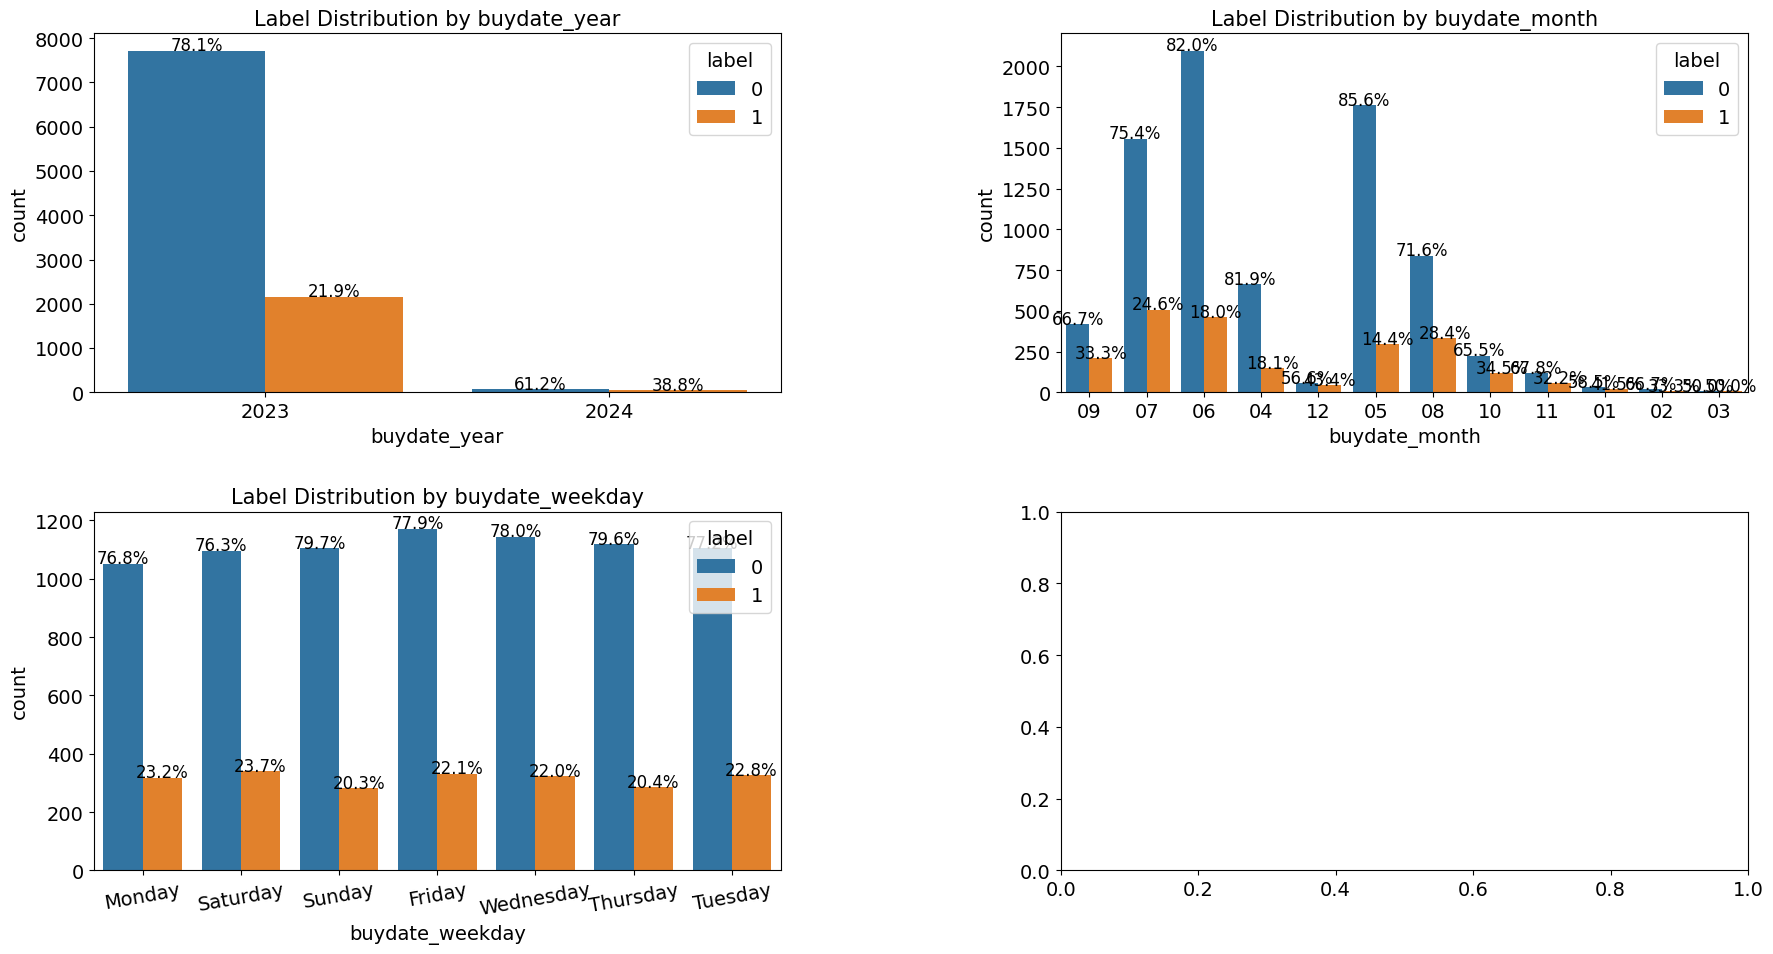

In [23]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열 Figure 생성
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(20,10) # 전체 Figure 크기를 10 x 9인치로 설정

sns.countplot(x='buydate_year', data=train, hue='label', ax=axes[0,0])
sns.countplot(x='buydate_month', data=train, hue='label', ax=axes[0,1])
sns.countplot(x='buydate_weekday', data=train, hue='label', ax=axes[1,0])

axes[0, 0].set(title='Label Distribution by buydate_year')
axes[0, 1].set(title='Label Distribution by buydate_month')
axes[1, 0].set(title='Label Distribution by buydate_weekday')
axes[1, 0].tick_params(axis='x', labelrotation=10)

write_percent(axes[0,0])

write_percent(axes[0,1])

write_percent(axes[1,0])

### Num. prod, insp. wtcd 에 따른 label 분포

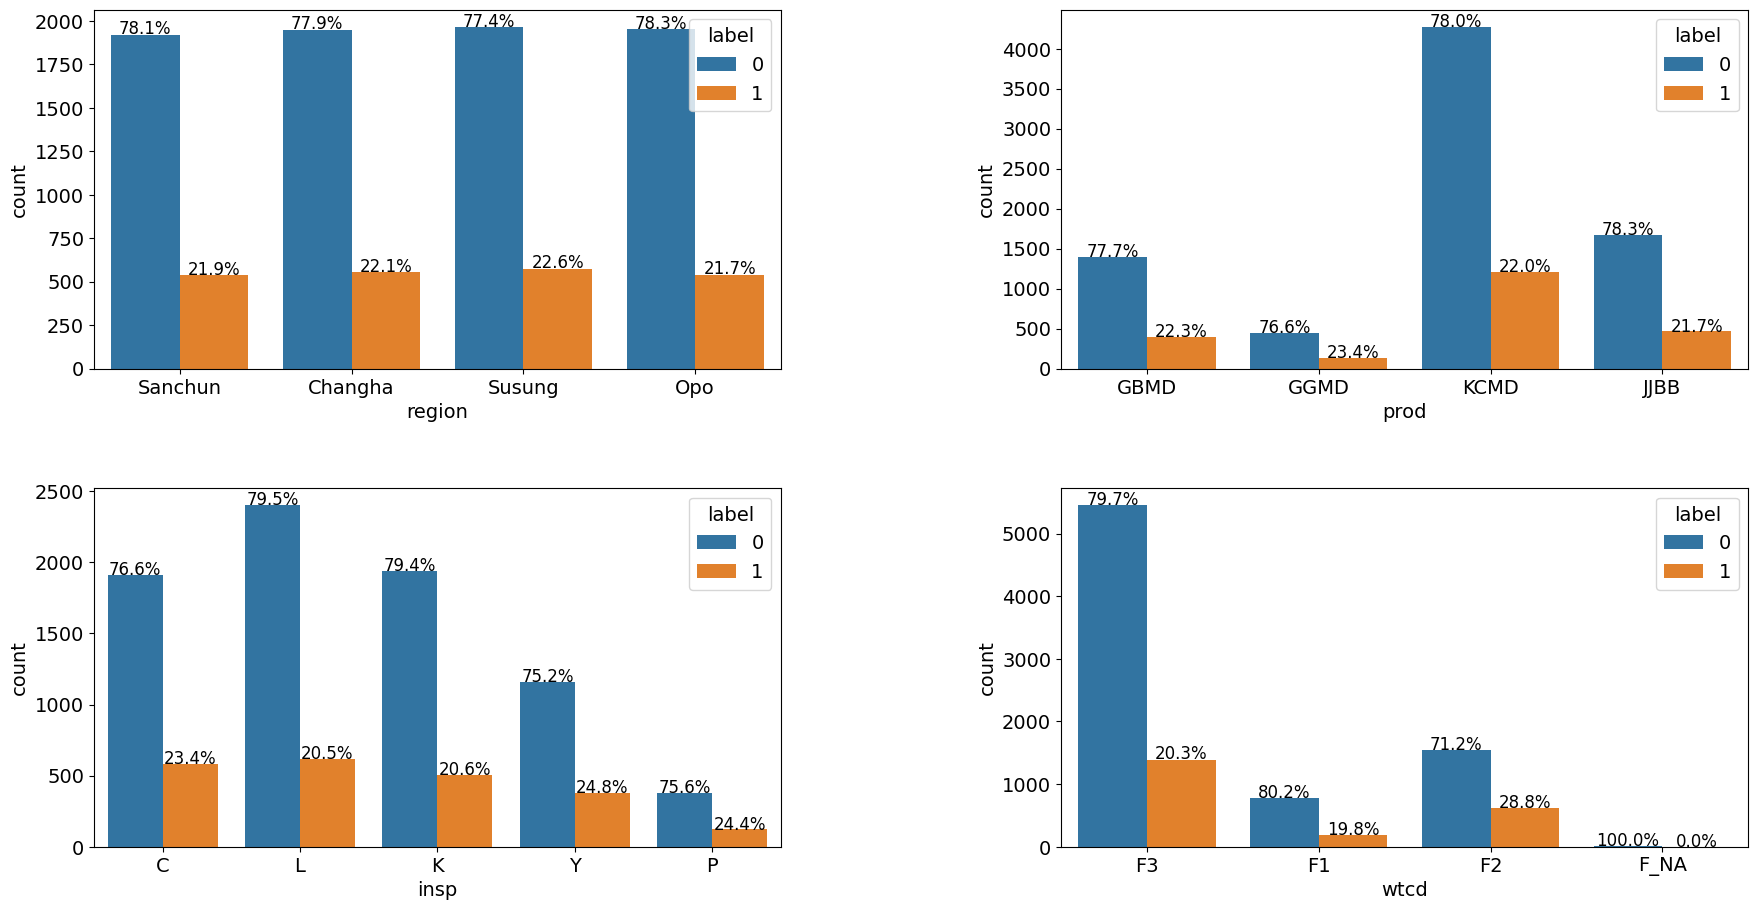

In [24]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열 Figure 생성
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(20,10) # 전체 Figure 크기를 10 x 9인치로 설정

sns.countplot(x='region', data=train, hue='label', ax=axes[0,0])
sns.countplot(x='prod', data=train, hue='label', ax=axes[0,1])
sns.countplot(x='insp', data=train, hue='label', ax=axes[1,0])

train_fill_Na = train.copy()
train_fill_Na['wtcd'] = train['wtcd'].fillna('F_NA')
sns.countplot(x='wtcd', data=train_fill_Na, hue='label', ax=axes[1,1])

write_percent(axes[0,0])

write_percent(axes[0,1])

write_percent(axes[1,0])


write_percent(axes[1,1])

#### Checking Null Value in column `wtcd`

In [25]:
train[train['wtcd'].isnull()]

,Num,prod,insp,date,buydate,ingr_A,ingr_B,ingr_C,wtcd,gram,...,region,date_year,date_month,date_day,buydate_year,buydate_month,buydate_day,date_weekday,buydate_weekday,days_between
152,A,KCMD,K,2023-05-08,2023-05-12,128.3390,6.8925,6.2336,NaN,491.08,...,Opo,2023,05,08,2023,05,12,Monday,Friday,4
1500,A,JJBB,K,2023-04-20,2023-06-17,319.0863,64811.0000,6.7270,NaN,1972.70,...,Opo,2023,04,20,2023,06,17,Thursday,Saturday,58
1867,A,KCMD,C,2023-06-05,2023-06-20,401.9915,6.3852,6.9117,NaN,786.90,...,Sanchun,2023,06,05,2023,06,20,Monday,Tuesday,15
2965,A,JJBB,C,2023-05-20,2023-06-17,131.5546,7.4636,6.1067,NaN,1782.97,...,Opo,2023,05,20,2023,06,17,Saturday,Saturday,28
3159,A,KCMD,C,2023-06-10,2023-07-12,400.2173,6.0006,6.9271,NaN,769.65,...,Opo,2023,06,10,2023,07,12,Saturday,Wednesday,32
3503,A,KCMD,K,2023-06-13,2023-06-26,396.8673,6.2746,6.9455,NaN,769.83,...,Opo,2023,06,13,2023,06,26,Tuesday,Monday,13
4750,A,GBMD,L,2023-04-14,2023-10-12,321.9846,74528.0000,6.1506,NaN,897.94,...,Opo,2023,04,14,2023,10,12,Friday,Thursday,181
6213,B,KCMD,K,2023-04-23,2023-07-07,318.4377,6.3588,6.4903,NaN,677.45,...,Changha,2023,04,23,2023,07,07,Sunday,Friday,75
8404,A,KCMD,C,2023-04-27,2023-09-30,321.5667,6.6244,5.8504,NaN,700.87,...,Sanchun,2023,04,27,2023,09,30,Thursday,Saturday,156
8801,A,JJBB,K,2023-04-13,2023-04-26,315.0384,5.8219,6.3853,NaN,1967.82,...,Changha,2023,04,13,2023,04,26,Thursday,Wednesday,13


### ingr_A, ingr_B, ingr_C, gram의 label에 따른 분포

<Axes: xlabel='label', ylabel='gram'>

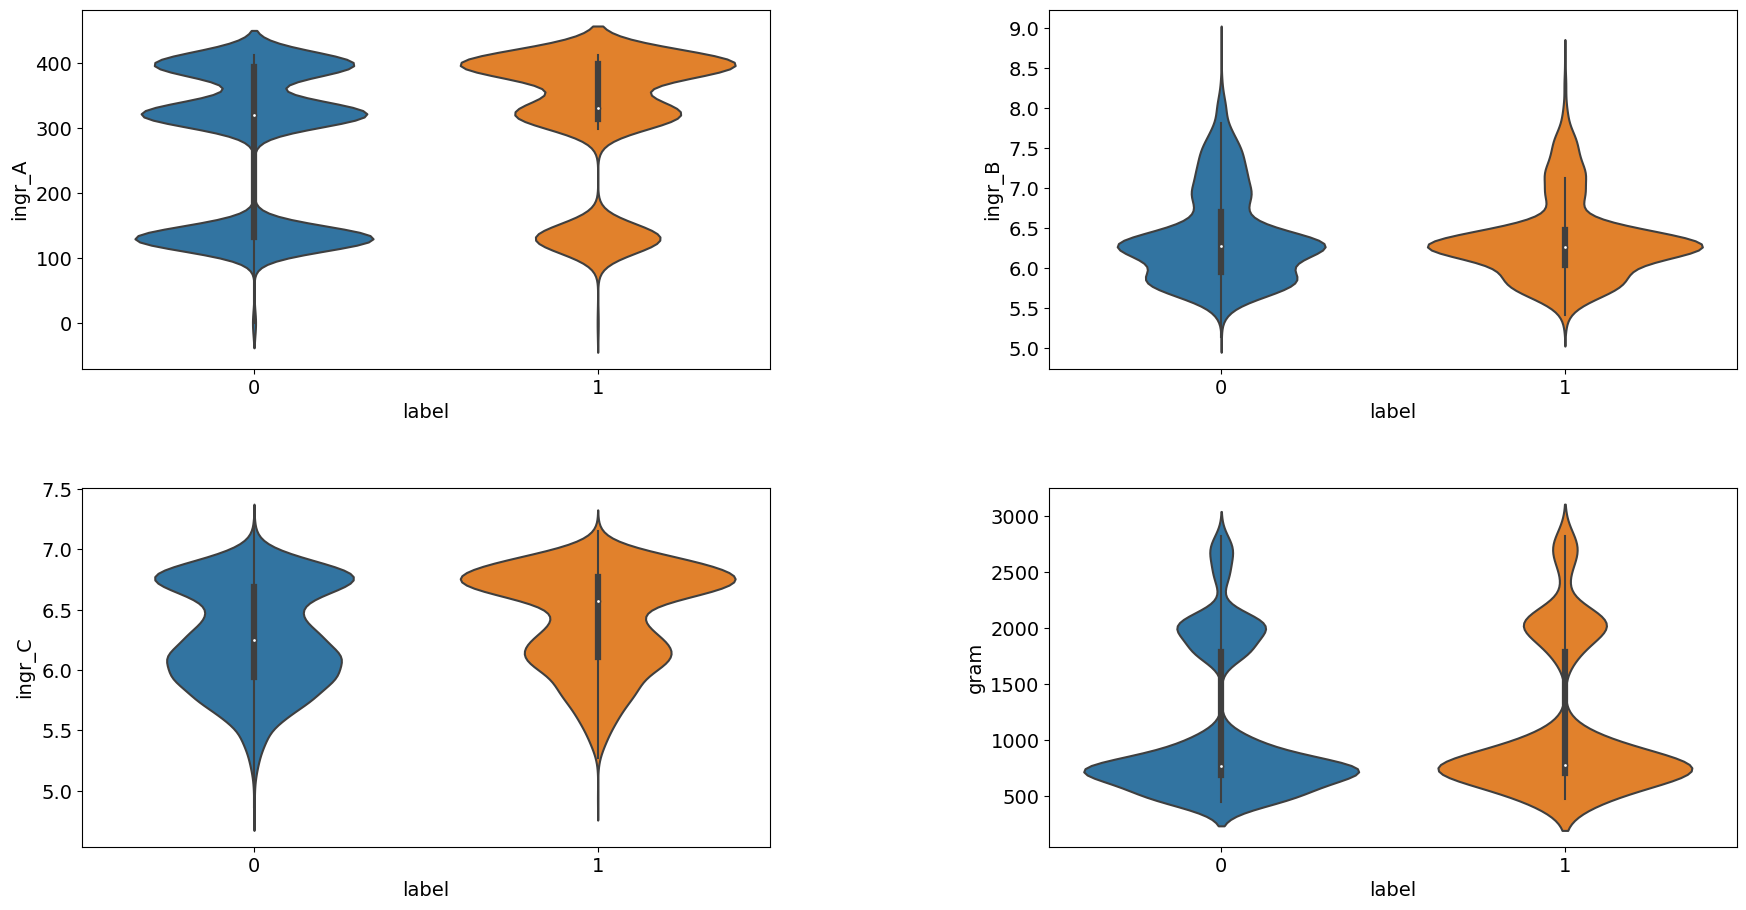

In [26]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열 Figure 생성
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(20,10) # 전체 Figure 크기를 10 x 9인치로 설정



ingr_B_outlier_delete_train = train.drop([1500,4750], axis=0, inplace=False)
sns.violinplot(x='label', data=ingr_B_outlier_delete_train, y='ingr_A', ax=axes[0,0])
sns.violinplot(x='label', data=ingr_B_outlier_delete_train, y='ingr_B', ax=axes[0,1])
sns.violinplot(x='label', data=ingr_B_outlier_delete_train, y='ingr_C', ax=axes[1,0])
sns.violinplot(x='label', data=ingr_B_outlier_delete_train, y='gram', ax=axes[1,1])



### 이상치 탐지

In [27]:
# 이상치 탐지 코드
def outlier_iqr(data, column):

    # lower, upper 글로벌 변수 선언하기
    global lower, upper

    # 4분위수 기준 지정하기
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)

    # IQR 계산하기
    iqr = q75 - q25

    # outlier cutoff 계산하기
    cut_off = iqr * 3.0

    # lower와 upper bound 값 구하기
    lower, upper = q25 - cut_off, q75 + cut_off

    print('IQR은',iqr, '이다.')
    print('lower bound 값은', lower, '이다.')
    print('upper bound 값은', upper, '이다.')

    # 1사 분위와 4사 분위에 속해있는 데이터 각각 저장하기
    upper_outlier = data[data[column] > upper]
    lower_outlier = data[data[column] < lower]

    return upper_outlier, lower_outlier

In [28]:
ingrB_upper_outlier, ingrB_lower_outlier = outlier_iqr(train, 'ingr_B')

IQR은 0.6488749999999994 이다.
lower bound 값은 4.025125000000002 이다.
upper bound 값은 8.567249999999998 이다.


In [29]:
ingrB_upper_outlier

,Num,prod,insp,date,buydate,ingr_A,ingr_B,ingr_C,wtcd,gram,...,region,date_year,date_month,date_day,buydate_year,buydate_month,buydate_day,date_weekday,buydate_weekday,days_between
1500,A,JJBB,K,2023-04-20,2023-06-17,319.0863,64811.0000,6.7270,NaN,1972.70,...,Opo,2023,04,20,2023,06,17,Thursday,Saturday,58
3267,A,KCMD,L,2023-05-02,2023-05-21,130.8646,8.8336,5.8270,F3,527.82,...,Changha,2023,05,02,2023,05,21,Tuesday,Sunday,19
4750,A,GBMD,L,2023-04-14,2023-10-12,321.9846,74528.0000,6.1506,NaN,897.94,...,Opo,2023,04,14,2023,10,12,Friday,Thursday,181
6733,A,KCMD,L,2023-04-03,2023-08-13,322.0534,8.6437,5.6991,F3,709.95,...,Sanchun,2023,04,03,2023,08,13,Monday,Sunday,132


### days_between의 라벨에 따른 분포

<Axes: xlabel='label', ylabel='days_between'>

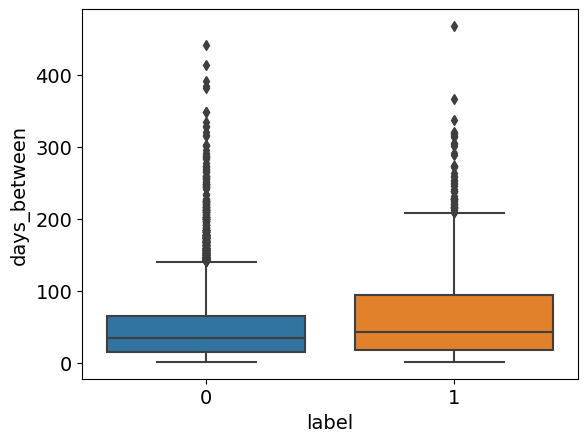

In [30]:
sns.boxplot(x='label', data=train, y='days_between')